In [2]:
]activate learning_ds

  Activating new environment at `~/project/notebooks/learning_ds/Project.toml`


In [3]:
include("../code/learn_polynomial_with_side_info.jl")
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
using CSV
using DataFrames
using DataFramesMeta
using Dates
using TimeSeries
using DynamicPolynomials
using Random

LoadError: LoadError: ArgumentError: Package JuMP not found in current path:
- Run `import Pkg; Pkg.add("JuMP")` to install the JuMP package.

in expression starting at /home/user/project/code/learn_polynomial_with_side_info.jl:1

# True vectorfield

Solving ODE from x0=[1.8, 0.5]
size(sol) = (2, 9)
length = 20


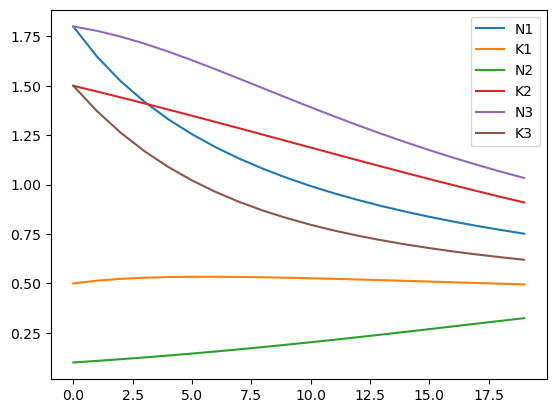

Solving ODE from x0=[0.1, 1.5]
size(sol) = (2, 6)
length = 20
Solving ODE from x0=[1.8, 1.5]
size(sol) = (2, 9)
length = 20


PyObject <matplotlib.legend.Legend object at 0x7f65b5aeeee0>

In [4]:
#μ, ν, α, ω, γ = 1., .25, .1, .5, .1
# μ, ν, ω, γ = .1, 1.,  .2, .1
μ, ν, ω, γ = .1, .5,  .1, .2

function two_compartment_model_vf(μ, ν, ω, γ)
    vf(N, K) = begin
         if  (N <= 0)  ||(K <= 0) #|| (N > K)
             return [0., 0.]
         else
            return [ 
            #-μ * N * log(N/K),
            μ/ν * N  * (1. - (N/K)^ν), 
            ω * N - γ * N^(2. /3) * K 
            ]
         end
    end
    return vf
end


initial_cdts = [ #(.2, 1),
    (1.8, .5),
    (.1, 1.5),
    (1.8, 1.5),
    
]
Random.seed!(1)

#initial_cdts = [2*rand(1, 2) for i=1:5]

N_t = []
K_t = []
t_t = []
num_samples = 20
T = 10
dT = T /num_samples

true_vf = two_compartment_model_vf(μ, ν, ω, γ)
i = 0

for X0 in initial_cdts
    N0, K0 = X0 
    N_t_i, K_t_i = solve_ode(true_vf, [N0, K0]; verbose=true, 
        tspan = (0., T), length=num_samples)
    
    N_t = [N_t..., N_t_i...]
    K_t = [K_t..., K_t_i...]
    t_t = [t_t..., 0:dT:(T-dT)...]
    i += 1
    PyPlot.plot(N_t_i, label="N$i")
    PyPlot.plot(K_t_i, label="K$i")
end

PyPlot.legend()

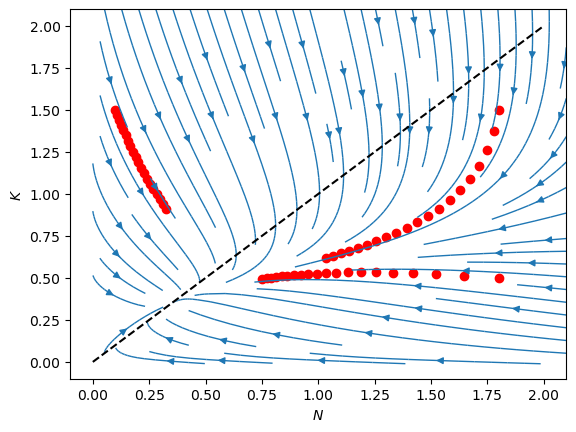

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f65b50bcd60>

In [5]:
#pyplot(size = (400,400))
plot_vectorfield(true_vf, (-.1, 2.1, 1000), (-.1, 2.1, 100))
PyPlot.scatter(N_t, K_t,  color=:red)
#PyPlot.plot([0, 10, 0, 0], [0, 10, 10, 0])
#PyPlot.plot([0, 4, 0, 0], [0, 4, 4, 0])
PyPlot.xlabel("\$N\$")
PyPlot.ylabel("\$K\$")
PyPlot.plot([0, 2], [0, 2], color=:black, ls="--")

In [6]:
ϵ = 1e-3
training_x = hcat(N_t, K_t)'
training_xdot = hcat(true_vf.(N_t, K_t)...)
# add noise
Random.seed!(1)
#training_x += ϵ * randn(size(training_x)...)
training_xdot += ϵ * randn(size(training_xdot)...)

2×60 Matrix{Float64}:
 -0.322755   -0.261037  -0.215961   …  -0.0666238  -0.0634319  -0.0595793
  0.0324097   0.021368   0.0141314     -0.0281364  -0.0241346  -0.024588

# learn poly from data

In [7]:
# side info

eq_at_zero(model, p, x) = [
    @constraint(model, coefficients(subs(pi, xi => 0)) .== 0) for (xi,pi)=zip(x,p)
    ]

decrease_rate_N(model, p, x) = begin
        Ω = @set (x[1] >= 0) && (x[2] >= 0) && (x[1] <= 2) && (x[2] <= 2)
        @constraint(model, -(x[1] * differentiate(p[1], x[1]) - p[1]) >= 0, domain=Ω)
end

N_positive(model, p, x) = begin
    N, K = x
    Ṅ, K̇ = p
    S = @set K >= 0 && K <= 2
    @constraint(model, Ṅ(N=>0, K=>K) >= 0, domain = S)
end 

K_positive(model, p, x) = begin        
    N, K = x
    Ṅ, K̇ = p
    S = @set N >= 0 && N <= 2
    @constraint(model, K̇(N=>N, K=>0) >= 0, domain = S)
    
end 

N_dot_positive_when_K_ge_N(model, p, x) = begin 
    N, K = x
    Ṅ, K̇ = p
    @constraint(model, Ṅ >= 0,
        domain=@set(N <= K && N >= 0 && K >= 0 && N <= 2 && K <= 2))
    
    
    @constraint(model, Ṅ <= 0,
        domain=@set(N >= K && N >= 0 && K >= 0 && N <= 2 && K <= 2))
end


side_info = Dict(
     #"equibilrium points" => eq_at_zero,
     "N_positive" => N_positive,
     "K_positive" => K_positive,
     #"N_dot_positive_when_K_ge_N" => N_dot_positive_when_K_ge_N,
     #"decrease_rate_N" => decrease_rate_N,
)

no_side_info = Dict()

d = 4
p_opt, opt_value = 
            fit_polynomial_to_data_with_side_info(training_x, training_xdot; 
    deg=d, verbose=false, 
    side_info=side_info)
    #side_info=side_info)
p_opt_as_f = (a, b) ->  map(pi -> pi([a,b]), p_opt)
@show opt_value

opt_value = 0.009410558861386415


0.009410558861386415

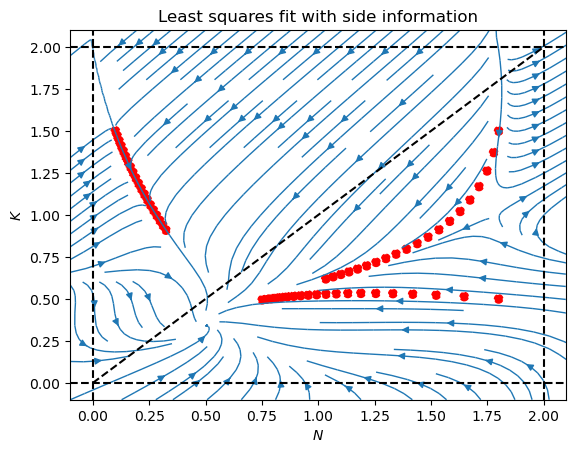

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6599124070>

In [8]:
vf = p_opt_as_f
vf_as_poly = p_opt
PyPlot.scatter(training_x[1, :], training_x[2, :], color=:red, ls="--", lw=1, label="training data")
PyPlot.title("Least squares fit with side information")

plot_vectorfield(vf, (-0.1, 2.1, 200), (-0.1, 2.1, 200))
PyPlot.xlim(-.1, 2.1)
PyPlot.ylim(-.1, 2.1)
PyPlot.xlabel("\$N\$")
PyPlot.ylabel("\$K\$")
PyPlot.axvline(0, color=:black, ls="--")
PyPlot.axhline(0, color=:black, ls="--")
PyPlot.axvline(2, color=:black, ls="--")
PyPlot.axhline(2, color=:black, ls="--")

PyPlot.plot([0, 2], [0, 2], color=:black, ls="--")